- [squareform에 대한 이해](https://silver-g-0114.tistory.com/61)

# Library

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf

# 한글 설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='white')

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#프로세스의 요구량만큼 메모리 사용 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# data : (10, 3595) 생성
- 10행 : `LSTM`, `GRU`, `RNN`, `xgboost`, `lightgbm`, `catboost`, `gradient boost`, `adaboost`, `RandomForest`, `permutation`

## Data Load (Xgboost ~ Adaboost)

In [2]:
import random  
seed_num = 42
random.seed(seed_num)

x = np.load('x_(7727,3595).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:], y[idx[:i]]
X_test, y_test = x[idx[i:],:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 3595), (6182,), (1545, 3595), (1545,))

## LSTM

In [3]:
# LSTM - 사망 마커
df1 = pd.read_csv('m1_df_3595.csv')
entropy_df = pd.read_csv('entropy_3595.csv')
LSTM_df = pd.merge(df1, entropy_df, how='inner', on='feature')
LSTM_df['score'] = LSTM_df['mean_diff'] * LSTM_df['entropy']
LSTM_df = LSTM_df.sort_values(by = 'feature', ascending = True)
LSTM_df

,feature,mean_diff,entropy,score
0,0,-0.038067,0.894548,-0.034053
1,50803,-0.004077,0.033443,-0.000136
2,50804,0.019238,0.484874,0.009328
3,50805,-0.019710,0.001172,-0.000023
4,50806,0.023554,0.074665,0.001759
...,...,...,...,...
3590,74312001370,0.019236,0.008062,0.000155
3591,78112001103,-0.016470,0.036891,-0.000608
3592,87701071218,0.025437,0.057111,0.001453
3593,87701083336,-0.007886,0.011373,-0.000090


## GRU

In [6]:
# 1. Best Model Saving

from tensorflow import keras
from sklearn import metrics 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import SimpleRNN, GRU
from tensorflow.keras.layers import Dropout, InputLayer, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import random
import sklearn

with tf.device('/device:GPU:0'):

    x = np.load('x_(7727,10,3595).npy')
    y = np.load('y_(7727,1).npy')

    # GRU model
    seed_num = 42 # model_seed
    tf.random.set_seed(seed_num)
    
    gru = Sequential()
    gru.add(InputLayer(input_shape=(x.shape[1],x.shape[2])))
    gru.add(GRU(units=128, activation='hard_sigmoid', return_sequences=True))
    gru.add(GRU(units=64, activation='hard_sigmoid', return_sequences=True))
    gru.add(Dropout(0.2))
    gru.add(GRU(units=64, activation='hard_sigmoid', return_sequences=True))
    gru.add(GRU(units=32, activation='hard_sigmoid', return_sequences=False))
    gru.add(Dropout(0.2))
    gru.add(Dense(units=1, activation='sigmoid'))

    from tensorflow.keras.callbacks import ModelCheckpoint
    import os

    MODEL_SAVE_FOLDER_PATH = f'./model/'
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
        os.mkdir(MODEL_SAVE_FOLDER_PATH)

    model_path = MODEL_SAVE_FOLDER_PATH + '/GRU_3595_{epoch:02d}-val_loss:{val_loss:.4f}.hdf5'

    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                    verbose=1, save_best_only=True)

    early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=False)
    
    gru.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
    gru.fit(x, y, validation_split=0.25, batch_size=128, epochs = 300,  callbacks=[early_stop, cb_checkpoint], shuffle=False)

Epoch 1/300
46/46 [==============================] - 6s 72ms/step - loss: 0.6536 - acc: 0.6464 - val_loss: 0.6927 - val_acc: 0.5135

Epoch 00001: val_loss improved from inf to 0.69267, saving model to ./model/GRU_3595_01-val_loss:0.6927.hdf5
Epoch 2/300
46/46 [==============================] - 3s 62ms/step - loss: 0.6806 - acc: 0.6005 - val_loss: 0.7115 - val_acc: 0.4865

Epoch 00002: val_loss did not improve from 0.69267
Epoch 3/300
46/46 [==============================] - 3s 64ms/step - loss: 0.6794 - acc: 0.6124 - val_loss: 0.7361 - val_acc: 0.4865

Epoch 00003: val_loss did not improve from 0.69267
Epoch 4/300
46/46 [==============================] - 3s 63ms/step - loss: 0.6633 - acc: 0.6385 - val_loss: 0.7251 - val_acc: 0.4865

Epoch 00004: val_loss did not improve from 0.69267
Epoch 5/300
46/46 [==============================] - 3s 64ms/step - loss: 0.6270 - acc: 0.6552 - val_loss: 0.6504 - val_acc: 0.4865

Epoch 00005: val_loss improved from 0.69267 to 0.65037, saving model to .


Epoch 00040: val_loss did not improve from 0.55093
Epoch 41/300
46/46 [==============================] - 3s 63ms/step - loss: 0.1004 - acc: 0.9755 - val_loss: 1.0149 - val_acc: 0.7433

Epoch 00041: val_loss did not improve from 0.55093
Epoch 42/300
46/46 [==============================] - 3s 63ms/step - loss: 0.0982 - acc: 0.9777 - val_loss: 0.9863 - val_acc: 0.7402

Epoch 00042: val_loss did not improve from 0.55093
Epoch 43/300
46/46 [==============================] - 3s 64ms/step - loss: 0.1013 - acc: 0.9755 - val_loss: 0.9842 - val_acc: 0.7459

Epoch 00043: val_loss did not improve from 0.55093
Epoch 44/300
46/46 [==============================] - 3s 63ms/step - loss: 0.0990 - acc: 0.9762 - val_loss: 0.9958 - val_acc: 0.7453

Epoch 00044: val_loss did not improve from 0.55093
Epoch 45/300
46/46 [==============================] - 3s 64ms/step - loss: 0.0967 - acc: 0.9765 - val_loss: 0.9923 - val_acc: 0.7417

Epoch 00045: val_loss did not improve from 0.55093
Epoch 46/300
46/46 [===

In [7]:
# 2. Dead Marker Important Score

# 1) DATA 
x = np.load('x_(7727,10,3595).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

total_data = pd.read_csv('total_data_7727_10_3595.csv')
features = total_data['ITEMID'].sort_values().unique()

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/GRU_3595_07-val_loss:0.5509.hdf5') # 3595용 모델

results = []
with tf.device('/device:GPU:0'):
    
    for i in tqdm(range(len(features))):

        save_col = x[:,:,i].copy()

        # 3) E(0to1)
        x[:,:,i] = np.where(x[:,:,i]==0, 1, x[:,:,i])
        pred_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        # 4) E(1to0)
        x[:,:,i] = np.where(x[:,:,i]==1, 0, x[:,:,i])
        pred_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        x[:,:,i] = save_col

        # 5) Merge
        mean_diff = pred_0to1 - pred_1to0
        results.append({'feature':features[i],'mean_diff':mean_diff})

Using TensorFlow backend.


  0%|          | 0/3595 [00:00<?, ?it/s]

In [8]:
df = pd.DataFrame(results)
# df.to_csv('m1_df_GRU_3595.csv', index = False)

In [4]:
# 3. 최종 점수 df

df1 = pd.read_csv('m1_df_GRU_3595.csv')
entropy_df = pd.read_csv('entropy_3595.csv')
GRU_df = pd.merge(df1, entropy_df, how='inner', on='feature')
GRU_df['score'] = GRU_df['mean_diff'] * GRU_df['entropy']
GRU_df = GRU_df.sort_values(by = 'feature', ascending = True)
GRU_df

,feature,mean_diff,entropy,score
0,0,-0.038527,0.894548,-0.034465
1,50803,-0.003219,0.033443,-0.000108
2,50804,0.034378,0.484874,0.016669
3,50805,-0.021184,0.001172,-0.000025
4,50806,0.022240,0.074665,0.001661
...,...,...,...,...
3590,74312001370,0.025268,0.008062,0.000204
3591,78112001103,-0.016117,0.036891,-0.000595
3592,87701071218,0.033337,0.057111,0.001904
3593,87701083336,0.008554,0.011373,0.000097


## RNN

In [ ]:
# 1. Best Model Saving

from tensorflow import keras
from sklearn import metrics 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import SimpleRNN, GRU
from tensorflow.keras.layers import Dropout, InputLayer, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import random
import sklearn

with tf.device('/device:GPU:0'):

    x = np.load('x_(7727,10,3595).npy')
    y = np.load('y_(7727,1).npy')

    # GRU model
    seed_num = 42 # model_seed
    tf.random.set_seed(seed_num)
    
    rnn = Sequential()
    rnn.add(InputLayer(input_shape=(x.shape[1],x.shape[2])))
    rnn.add(SimpleRNN(units=128, activation='hard_sigmoid', return_sequences=True))
    rnn.add(SimpleRNN(units=64, activation='hard_sigmoid', return_sequences=True))
    rnn.add(Dropout(0.2))
    rnn.add(SimpleRNN(units=64, activation='hard_sigmoid', return_sequences=True))
    rnn.add(SimpleRNN(units=32, activation='hard_sigmoid', return_sequences=False))
    rnn.add(Dropout(0.2))
    rnn.add(Dense(units=1, activation='sigmoid'))


    from tensorflow.keras.callbacks import ModelCheckpoint
    import os

    MODEL_SAVE_FOLDER_PATH = f'./model/'
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
        os.mkdir(MODEL_SAVE_FOLDER_PATH)

    model_path = MODEL_SAVE_FOLDER_PATH + '/RNN_3595_{epoch:02d}-val_loss:{val_loss:.4f}.hdf5'

    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                    verbose=1, save_best_only=True)

    early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=False)
    
    rnn.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
    rnn.fit(x, y, validation_split=0.25, batch_size=128, epochs = 300,  callbacks=[early_stop, cb_checkpoint], shuffle=False)

In [ ]:
# 2. Dead Marker Important Score

# 1) DATA 
x = np.load('x_(7727,10,3595).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

total_data = pd.read_csv('total_data_7727_10_3595.csv')
features = total_data['ITEMID'].sort_values().unique()

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/') # 3595용 모델

results = []
with tf.device('/device:GPU:0'):
    
    for i in tqdm(range(len(features))):

        save_col = x[:,:,i].copy()

        # 3) E(0to1)
        x[:,:,i] = np.where(x[:,:,i]==0, 1, x[:,:,i])
        pred_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        # 4) E(1to0)
        x[:,:,i] = np.where(x[:,:,i]==1, 0, x[:,:,i])
        pred_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        x[:,:,i] = save_col

        # 5) Merge
        mean_diff = pred_0to1 - pred_1to0
        results.append({'feature':features[i],'mean_diff':mean_diff})

In [ ]:
df = pd.DataFrame(results)
# df.to_csv('m1_df_RNN_3595.csv', index = False)

In [5]:
# 3. 최종 점수 df

df1 = pd.read_csv('m1_df_RNN_3595.csv')
entropy_df = pd.read_csv('entropy_3595.csv')
RNN_df = pd.merge(df1, entropy_df, how='inner', on='feature')
RNN_df['score'] = RNN_df['mean_diff'] * RNN_df['entropy']
RNN_df = RNN_df.sort_values(by = 'feature', ascending = True)
RNN_df

,feature,mean_diff,entropy,score
0,0,-0.022926,0.894548,-0.020509
1,50803,0.019970,0.033443,0.000668
2,50804,0.036500,0.484874,0.017698
3,50805,-0.007613,0.001172,-0.000009
4,50806,0.030775,0.074665,0.002298
...,...,...,...,...
3590,74312001370,0.018977,0.008062,0.000153
3591,78112001103,-0.009410,0.036891,-0.000347
3592,87701071218,0.019204,0.057111,0.001097
3593,87701083336,-0.006022,0.011373,-0.000068


## Xgboost

In [ ]:
# 1. Xgboost model 정의 및 성능 측정
from xgboost import XGBClassifier
model = XGBClassifier() 
model.fit(X_train, y_train)

# 2. FI df 생성
features = list(pd.read_csv('total_data_7727_10_3595.csv')['ITEMID'].sort_values().unique())
XGB_df = pd.DataFrame(features, columns=['feature'])
XGB_df['score'] = model.feature_importances_
XGB_df = XGB_df.sort_values(by = 'score', ascending = False)

# XGB_df.to_csv('XGB_FI_3595.csv', index = False)

In [6]:
XGB_df = pd.read_csv('XGB_FI_3595.csv')
XGB_df = XGB_df.sort_values(by = 'feature', ascending = True)
XGB_df

,feature,score
19,0,0.004310
154,50803,0.001867
552,50804,0.000669
2519,50805,0.000000
184,50806,0.001767
...,...,...
882,74312001370,0.000000
135,78112001103,0.001953
814,87701071218,0.000000
790,87701083336,0.000000


## Lightgbm

In [ ]:
# 1. Lightgbm model 정의 및 성능 측정
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(X_train, y_train)

# 2. FI df 생성
features = list(pd.read_csv('total_data_7727_10_3595.csv')['ITEMID'].sort_values().unique())
LGBM_df = pd.DataFrame(features, columns=['feature'])
LGBM_df['score'] = model.feature_importances_
LGBM_df = LGBM_df.sort_values(by = 'score', ascending = False)

# LGBM_df.to_csv('LGBM_FI_3595.csv', index = False)

In [7]:
LGBM_df = pd.read_csv('LGBM_FI_3595.csv')
LGBM_df = LGBM_df.sort_values(by = 'feature', ascending = True)
LGBM_df

,feature,score
46,0,12
568,50803,1
114,50804,8
2518,50805,0
40,50806,12
...,...,...
1453,74312001370,0
181,78112001103,6
1454,87701071218,0
1455,87701083336,0


## Catboost

In [ ]:
# 1. Catboost model 정의 및 성능 측정
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.fit(X_train, y_train)

# 2. FI df 생성
features = list(pd.read_csv('total_data_7727_10_3595.csv')['ITEMID'].sort_values().unique())
cat_df = pd.DataFrame(features, columns=['feature'])
cat_df['score'] = model.feature_importances_
cat_df = cat_df.sort_values(by = 'score', ascending = False)

# cat_df.to_csv('CAT_FI_3595.csv', index = False)

In [8]:
cat_df = pd.read_csv('CAT_FI_3595.csv')
cat_df = cat_df.sort_values(by = 'feature', ascending = True)
cat_df

,feature,score
62,0,0.328759
539,50803,0.018038
152,50804,0.140217
2609,50805,0.000000
84,50806,0.259910
...,...,...
1486,74312001370,0.000000
290,78112001103,0.065610
1239,87701071218,0.000000
1378,87701083336,0.000000


## Gradient Boost

In [ ]:
# 1. Gradient Boost model 정의 및 성능 측정
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# 2. FI df 생성
features = list(pd.read_csv('total_data_7727_10_3595.csv')['ITEMID'].sort_values().unique())
gb_df = pd.DataFrame(features, columns=['feature'])
gb_df['score'] = model.feature_importances_
gb_df = gb_df.sort_values(by = 'score', ascending = False)

# gb_df.to_csv('GB_FI_3595.csv', index = False)

In [9]:
gb_df = pd.read_csv('GB_FI_3595.csv')
gb_df = gb_df.sort_values(by = 'feature', ascending = True)
gb_df

,feature,score
31,0,0.006075
2958,50803,0.000000
2447,50804,0.000000
2448,50805,0.000000
2449,50806,0.000000
...,...,...
1314,74312001370,0.000000
188,78112001103,0.000539
1315,87701071218,0.000000
1316,87701083336,0.000000


## Adaboost

In [ ]:
# 1. AdaBoost model 정의 및 성능 측정
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# 2. FI df 생성
features = list(pd.read_csv('total_data_7727_10_3595.csv')['ITEMID'].sort_values().unique())
Ada_df = pd.DataFrame(features, columns=['feature'])
Ada_df['score'] = model.feature_importances_
Ada_df = Ada_df.sort_values(by = 'score', ascending = False)

# Ada_df.to_csv('ADA_FI_3595.csv', index = False)

In [10]:
Ada_df = pd.read_csv('ADA_FI_3595.csv')
Ada_df = Ada_df.sort_values(by = 'feature', ascending = True)
Ada_df

,feature,score
1,0,0.02
2996,50803,0.00
2402,50804,0.00
2403,50805,0.00
2404,50806,0.00
...,...,...
1224,74312001370,0.00
1225,78112001103,0.00
1226,87701071218,0.00
1227,87701083336,0.00


## RandomForest

In [ ]:
# 1. RF model 정의 및 성능 측정
model = RandomForestClassifier()
model.fit(X_train, y_train)

# 2. FI df 생성f
features = list(pd.read_csv('total_data_7727_10_3595.csv')['ITEMID'].sort_values().unique())
RF_df = pd.DataFrame(features, columns=['feature'])
RF_df['score'] = model.feature_importances_
RF_df = RF_df.sort_values(by = 'feature', ascending = True)
RF_df

# RF_df.to_csv('RF_FI_3595.csv', index = False)

In [11]:
RF_df = pd.read_csv('RF_FI_3595.csv')
RF_df = RF_df.sort_values(by = 'feature', ascending = True)
RF_df

,feature,score
146,0,0.001557
303,50803,0.000902
40,50804,0.003022
2513,50805,0.000012
135,50806,0.001637
...,...,...
3180,74312001370,0.000000
561,78112001103,0.000470
617,87701071218,0.000402
1302,87701083336,0.000108


## permutation

In [15]:
per = pd.read_csv('per_FI_3595.csv')
baseline_bce = float(per['baseline_bce'].dropna().unique())
per = per.iloc[1:]
per['score'] = per['bce'] - baseline_bce
per['feature'] = per['feature'].astype(int)
per = per.sort_values(by='feature', ascending = True)
per

,feature,baseline_bce,bce,score
1,0,NaN,0.987529,0.000549
2,50803,NaN,0.986999,0.000019
3,50804,NaN,0.987403,0.000424
4,50805,NaN,0.986977,-0.000003
5,50806,NaN,0.986882,-0.000098
...,...,...,...,...
3591,74312001370,NaN,0.986940,-0.000039
3592,78112001103,NaN,0.986903,-0.000076
3593,87701071218,NaN,0.986854,-0.000126
3594,87701083336,NaN,0.986984,0.000004


## data (10, 3595)

In [16]:
data = np.array([LSTM_df['score'].values, GRU_df['score'].values, RNN_df['score'].values, 
                 XGB_df['score'].values, LGBM_df['score'].values, cat_df['score'].values, 
                 gb_df['score'].values, Ada_df['score'].values, RF_df['score'].values, per['score'].values])
data
data.shape

array([[-3.40528317e-02, -1.36349812e-04,  9.32799885e-03, ...,
         1.45273518e-03, -8.96875276e-05, -8.66867194e-05],
       [-3.44646691e-02, -1.07637874e-04,  1.66687548e-02, ...,
         1.90389850e-03,  9.72784224e-05, -8.21619091e-05],
       [-2.05087452e-02,  6.67859531e-04,  1.76977652e-02, ...,
         1.09675607e-03, -6.84854899e-05, -6.85751128e-05],
       ...,
       [ 2.00000000e-02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.55655939e-03,  9.01562585e-04,  3.02194623e-03, ...,
         4.02319914e-04,  1.07895023e-04,  1.76353287e-05],
       [ 5.49197197e-04,  1.91330910e-05,  4.23729420e-04, ...,
        -1.25706196e-04,  4.11272049e-06, -2.98023224e-06]])

(10, 3595)

# Correlation Clustering Dendrogram
- [skLearn을 이용한 계층 분석 모델 구현](https://bcho.tistory.com/1204)
- [scipy.spatial.distance.squareform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html)

In [19]:
# 1. dissimilarity (1, 45)

from scipy import stats
from itertools import combinations

dissimilarity = []
idx_pair_lst = list(combinations(range(10), 2))
for i in idx_pair_lst:
    dissimilarity.append((1 - stats.spearmanr(data[i[0]], data[i[1]])[0]) * 0.5)

len(dissimilarity)

45

<ipython-input-28-2975af2139a2>:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = linkage(squareform(dissimilarity), 'ward')


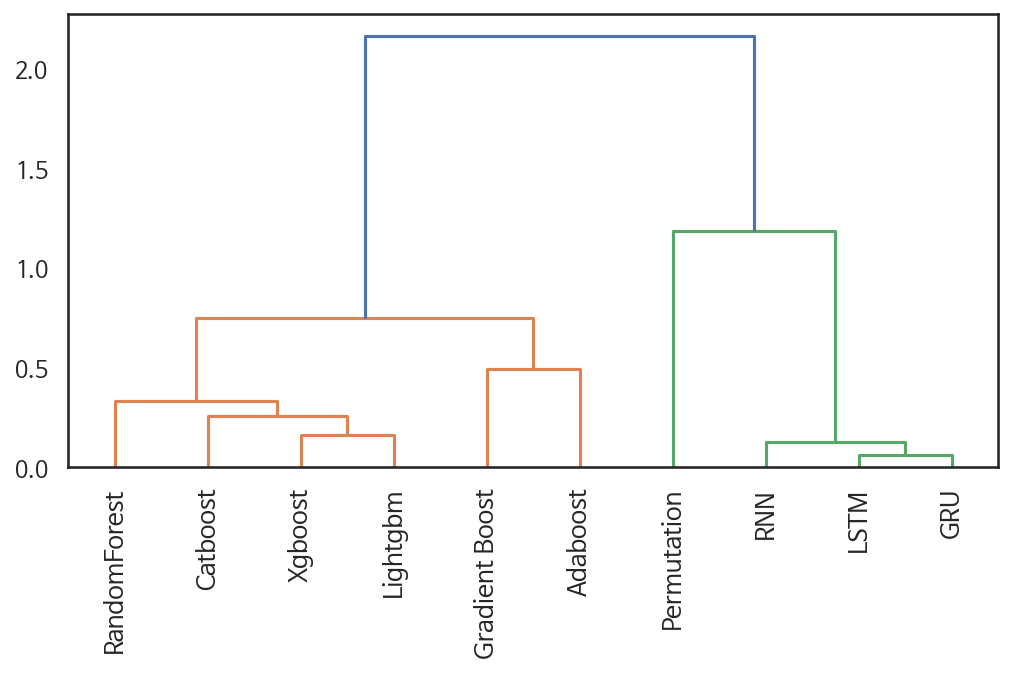

In [28]:
# 2. Clustering
# option = 'complete', 'average', 'ward'

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
linkage = linkage(squareform(dissimilarity), 'ward') 

# 3. Dendrogram
from scipy.cluster.hierarchy import dendrogram

label = ['LSTM', 'GRU', 'RNN', 'Xgboost', 'Lightgbm', 'Catboost', 'Gradient Boost', 'Adaboost', 'RandomForest', 'Permutation']
plt.figure(figsize = (8, 4), dpi=150)
dendrogram(linkage, labels = label, orientation='top', leaf_rotation=90);